<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/click-sequence-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Sequences of Clicks on the Server

Make sure to run this from top to bottom to export model, otherwise names of layers cause tf.js to bail out

In [0]:
# for colab
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190728


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [7]:
import pandas as pd
print(pd.__version__)

0.24.2


In [8]:
import numpy as np
print(np.__version__)

1.16.4


In [0]:
# local
# URL = '../data/click-sequence.json'

# remote
URL = 'https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master//data/click-sequence.json'


df = pd.read_json(URL, typ='series')

In [10]:
len(df)

51

In [11]:
df.head()

0                                                   []
1                   [train-model, save-model-to-local]
2                      [load-local-model, train-model]
3    [load-local-model, train-model, toggle-visor, ...
4    [train-model, show-eval, train-model, save-mod...
dtype: object

In [12]:
type(df[0])

list

In [13]:
df[0], df[1]

([], ['train-model', 'save-model-to-local'])

In [14]:
all_buttons = set()
for seq in df:
  for button in seq:
    all_buttons.add(button)

all_buttons.add('<START>')
all_buttons.add('<EMPTY>')

all_buttons = list(all_buttons)

print(all_buttons)

['upload-model', '<EMPTY>', 'save-model-to-local', 'show-eval', 'train-model', '<START>', 'reset-data', 'toggle-prediction', 'show-model', 'load-local-model', 'reset-model', 'download-model', 'toggle-visor', 'load-remote-model']


In [15]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_buttons)
encoder.classes_

array(['<EMPTY>', '<START>', 'download-model', 'load-local-model',
       'load-remote-model', 'reset-data', 'reset-model',
       'save-model-to-local', 'show-eval', 'show-model',
       'toggle-prediction', 'toggle-visor', 'train-model', 'upload-model'],
      dtype='<U19')

In [16]:
transfomed_labels = [encoder.transform(seq) for seq in df if len(seq) != 0]
print(transfomed_labels)

[array([12,  7]), array([ 3, 12]), array([ 3, 12, 11, 11, 12,  6, 12]), array([12,  8, 12,  7]), array([ 3, 12,  8,  7,  2, 11, 10]), array([12,  9, 11,  8, 11, 11,  7, 10]), array([12, 11,  7, 11,  8,  5, 12, 11,  7,  8,  8,  8]), array([12, 12,  7,  8, 11, 10,  7,  2]), array([13, 13, 13, 13, 10]), array([ 5, 12, 10,  8, 10, 10, 10, 11, 10, 10,  6, 12, 11,  7, 12,  7,  8,
        8, 10, 11, 10,  6, 12, 11,  7,  8,  8, 10, 10]), array([12,  7, 11,  2, 10, 13, 13, 11,  8,  8]), array([13, 13, 10,  5, 10]), array([12, 10, 11]), array([12]), array([12,  8,  6, 12, 11, 11, 11,  8,  8, 12,  6, 12,  7,  8,  8,  5,  6,
       12, 11,  8,  8, 11,  6, 12, 11,  7, 11, 10, 10, 12, 11, 11, 10, 10,
       12, 11,  7,  8,  8, 11, 10]), array([12]), array([12]), array([12,  3, 10, 11, 10]), array([10,  3,  3, 10, 10, 10, 12, 11, 11,  8,  8, 10, 11, 12]), array([12, 11]), array([12,  8, 11, 11, 10, 10, 11, 11]), array([12]), array([12,  8]), array([11, 11, 11,  8]), array([12,  8, 11, 11]), array([12

## pre-process data into chunks

In [0]:
empty = encoder.transform(['<EMPTY>'])
start = encoder.transform(['<START>'])
chunk_size = 5

In [0]:
# [ 1, 11,  7, 11,  6] => [[[0, 0, 0, 0, 1], 11], [[0, 0, 0, 1, 11], 7], [[0, 0, 1, 11, 7], 11], [[0, 1, 11, 7, 11], 6]]

def create_sequences(seq, chunk_size, empty, start):
  # all sequences implicitly start
  seq = np.append(start, seq)
  # if sequence is too short, we pad it to minimum size at the beginning
  seq = np.append(np.full(chunk_size - 1, empty), seq)
  
  seqs = np.array([])
  for index in range(chunk_size, len(seq)):
    y = seq[index]
    x = seq[index-chunk_size : index]
    seqs = np.append(seqs, [x, y])
  return seqs

In [19]:

# seq = transfomed_labels[0]
# seq = transfomed_labels[9]
seq = transfomed_labels[3]
seq

array([12,  8, 12,  7])

In [20]:
create_sequences(seq, chunk_size, empty, start)

array([array([0, 0, 0, 0, 1]), 12, array([ 0,  0,  0,  1, 12]), 8,
       array([ 0,  0,  1, 12,  8]), 12, array([ 0,  1, 12,  8, 12]), 7],
      dtype=object)

In [21]:
seqs = np.array([])
for seq in transfomed_labels:
  seqs = np.append(seqs, create_sequences(seq, chunk_size, empty, start))
seqs = seqs.reshape(-1, 2)
seqs.shape

(279, 2)

In [22]:
X = seqs[:, 0]
# X = X.reshape(-1, chunk_size)
X = np.vstack(X)
X.shape

(279, 5)

In [23]:
y = seqs[:, 1]
y

array([12, 7, 3, 12, 3, 12, 11, 11, 12, 6, 12, 12, 8, 12, 7, 3, 12, 8, 7,
       2, 11, 10, 12, 9, 11, 8, 11, 11, 7, 10, 12, 11, 7, 11, 8, 5, 12,
       11, 7, 8, 8, 8, 12, 12, 7, 8, 11, 10, 7, 2, 13, 13, 13, 13, 10, 5,
       12, 10, 8, 10, 10, 10, 11, 10, 10, 6, 12, 11, 7, 12, 7, 8, 8, 10,
       11, 10, 6, 12, 11, 7, 8, 8, 10, 10, 12, 7, 11, 2, 10, 13, 13, 11,
       8, 8, 13, 13, 10, 5, 10, 12, 10, 11, 12, 12, 8, 6, 12, 11, 11, 11,
       8, 8, 12, 6, 12, 7, 8, 8, 5, 6, 12, 11, 8, 8, 11, 6, 12, 11, 7, 11,
       10, 10, 12, 11, 11, 10, 10, 12, 11, 7, 8, 8, 11, 10, 12, 12, 12, 3,
       10, 11, 10, 10, 3, 3, 10, 10, 10, 12, 11, 11, 8, 8, 10, 11, 12, 12,
       11, 12, 8, 11, 11, 10, 10, 11, 11, 12, 12, 8, 11, 11, 11, 8, 12, 8,
       11, 11, 12, 12, 12, 8, 12, 6, 12, 12, 8, 12, 11, 5, 12, 8, 12, 8,
       12, 12, 12, 8, 11, 12, 11, 8, 8, 6, 12, 8, 8, 6, 12, 12, 12, 8, 8,
       10, 11, 7, 2, 11, 10, 10, 10, 12, 8, 11, 8, 10, 11, 10, 12, 12, 8,
       11, 11, 10, 10, 10, 11, 11, 8, 1

## Training

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 2
n_buttons = len(encoder.classes_)

dropout = .6
recurrent_dropout = .6

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_buttons, 
                    output_dim=embedding_dim, 
                    input_length=chunk_size))

model.add(SimpleRNN(units=50, activation='relu', name="RNN", recurrent_dropout=recurrent_dropout))
# model.add(GRU(units=25, activation='relu', name="RNN", recurrent_dropout=0.5))
# model.add(LSTM(units=25, activation='relu', name="RNN", recurrent_dropout=0.5))

model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 2)              28        
_________________________________________________________________
RNN (SimpleRNN)              (None, 50)                2650      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
softmax (Dense)              (None, 14)                714       
Total params: 3,592
Trainable params: 3,492
Non-trainable params: 100
_________________________________________________________________


In [30]:
%%time

EPOCHS = 1000
BATCH_SIZE = 100

history = model.fit(X, y, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

CPU times: user 2min 56s, sys: 14.6 s, total: 3min 10s
Wall time: 2min 1s


In [31]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
accuracy

279/279 [==============================] - 0s 796us/sample - loss: 1.2082 - accuracy: 0.5986


0.5985663

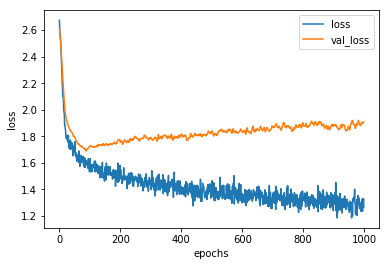

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

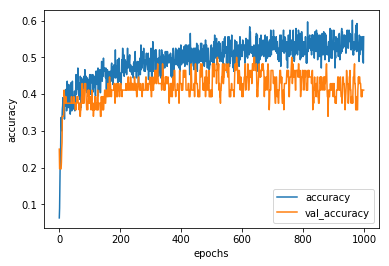

In [33]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

# TF 2.0
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

plt.legend(['accuracy', 'val_accuracy'])

In [34]:
model.predict([[X[0]]])

array([[8.2155075e-06, 7.0649203e-06, 2.7443617e-04, 8.9549869e-02,
        7.4284012e-06, 4.3790173e-02, 2.9159831e-03, 9.2941412e-04,
        2.5820679e-03, 3.5484630e-04, 2.2838922e-02, 1.2494260e-02,
        7.8079081e-01, 4.3456476e-02]], dtype=float32)

In [35]:
model.predict([[X[0]]]).argmax()

12

In [36]:
y[0]

12

In [37]:
y_pred = model.predict([X]).argmax(axis=1)
y_pred

array([12,  8, 12, 12, 12, 12,  8,  8, 10,  6, 12, 12,  8, 11,  6, 12, 12,
        8,  8,  2, 11, 10, 12,  8, 11,  8, 11, 11, 11, 11, 12,  8, 11,  8,
        8,  8, 12, 11, 11,  8,  8, 10, 12,  8,  8,  8,  8, 10, 10,  2, 12,
       13, 10, 13, 10, 12, 12,  8,  8, 10, 10, 10, 10, 10, 10, 10, 12, 11,
        7,  8,  7,  8,  8, 10, 10, 10, 10, 12, 11,  7,  8,  8, 10, 10, 12,
        8, 11,  8, 10, 10, 13, 11,  8,  8, 12, 13, 10,  5, 10, 12,  8, 11,
       12, 12,  8, 11, 12, 11, 11, 10, 10,  8, 10,  6, 12,  7,  8,  8, 10,
       12, 12, 11,  8,  8, 10, 11, 12, 11,  7,  8,  8, 10, 12, 11, 11, 10,
       10, 10, 11, 11,  8,  8, 10, 11, 12, 12, 12,  8, 10, 10, 10, 12, 12,
       10, 12, 10, 10, 10, 11, 11, 10,  8, 10, 10, 10, 12,  8, 12,  8, 11,
       11, 10, 10, 12, 10, 12, 12,  8, 12, 11, 11, 10, 12,  8, 11, 11, 12,
       12, 12,  8, 11,  6, 12, 12,  8, 11,  6, 12, 12,  8, 12,  8, 12, 12,
        8,  8,  8, 10,  6,  8,  8, 10, 12,  8,  8, 10, 12,  8,  8,  8,  8,
       10, 10, 10, 11, 11

In [38]:
y

array([12, 7, 3, 12, 3, 12, 11, 11, 12, 6, 12, 12, 8, 12, 7, 3, 12, 8, 7,
       2, 11, 10, 12, 9, 11, 8, 11, 11, 7, 10, 12, 11, 7, 11, 8, 5, 12,
       11, 7, 8, 8, 8, 12, 12, 7, 8, 11, 10, 7, 2, 13, 13, 13, 13, 10, 5,
       12, 10, 8, 10, 10, 10, 11, 10, 10, 6, 12, 11, 7, 12, 7, 8, 8, 10,
       11, 10, 6, 12, 11, 7, 8, 8, 10, 10, 12, 7, 11, 2, 10, 13, 13, 11,
       8, 8, 13, 13, 10, 5, 10, 12, 10, 11, 12, 12, 8, 6, 12, 11, 11, 11,
       8, 8, 12, 6, 12, 7, 8, 8, 5, 6, 12, 11, 8, 8, 11, 6, 12, 11, 7, 11,
       10, 10, 12, 11, 11, 10, 10, 12, 11, 7, 8, 8, 11, 10, 12, 12, 12, 3,
       10, 11, 10, 10, 3, 3, 10, 10, 10, 12, 11, 11, 8, 8, 10, 11, 12, 12,
       11, 12, 8, 11, 11, 10, 10, 11, 11, 12, 12, 8, 11, 11, 11, 8, 12, 8,
       11, 11, 12, 12, 12, 8, 12, 6, 12, 12, 8, 12, 11, 5, 12, 8, 12, 8,
       12, 12, 12, 8, 11, 12, 11, 8, 8, 6, 12, 8, 8, 6, 12, 12, 12, 8, 8,
       10, 11, 7, 2, 11, 10, 10, 10, 12, 8, 11, 8, 10, 11, 10, 12, 12, 8,
       11, 11, 10, 10, 10, 11, 11, 8, 1

In [39]:
# TF 2.0
cm = tf.math.confusion_matrix(labels=tf.constant(y, dtype=tf.int64), predictions=tf.constant(y_pred, dtype=tf.int64))
cm

<tf.Tensor: id=102505, shape=(14, 14), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  4,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  4,  2,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  5,  4,  0,  2,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 42,  0, 10,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  5,  0, 32,  2,  5,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0, 12,  0, 13, 31,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  8,  3, 47,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  2,  4]],
      dtype=int32)>

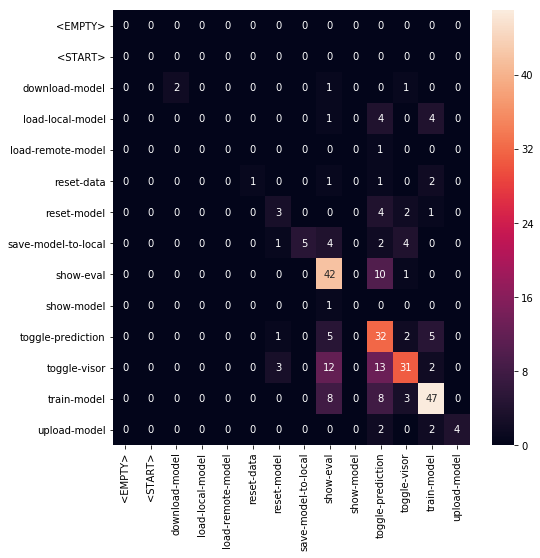

In [40]:
import seaborn as sns

classes = encoder.classes_

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

In [0]:
# sns.heatmap?

In [58]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(X)
embeddings_2d.shape

(279, 5, 2)

In [59]:
embeddings_2d

array([[[-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [ 0.16050503, -0.14630839]],

       [[-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [ 0.16050503, -0.14630839],
        [-0.31363907, -0.09648325]],

       [[-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [ 0.16050503, -0.14630839]],

       ...,

       [[-0.11615247,  0.130757  ],
        [-0.01070085, -0.00391349],
        [-0.01070085, -0.00391349],
        [-0.01070085, -0.00391349],
        [ 0.01248433,  0.01787362]],

       [[-0.01070085, -0.00391349],
        [-0.01070085, -0.00391349],
        [-0.01070085, -0.00391349],
        [ 0.01248433,  0.01787362],
        [-0.31363907, -0.09648325]],

       [[-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
     

In [61]:
encoder.classes_

array(['<EMPTY>', '<START>', 'download-model', 'load-local-model',
       'load-remote-model', 'reset-data', 'reset-model',
       'save-model-to-local', 'show-eval', 'show-model',
       'toggle-prediction', 'toggle-visor', 'train-model', 'upload-model'],
      dtype='<U19')

In [0]:
encoded_classes = encoder.transform(encoder.classes_)

In [0]:
same_button_seqs = np.repeat(encoded_classes, 5).reshape(14, 5)

In [80]:
embeddings_2d = embedding_model.predict(same_button_seqs)
embeddings_2d.shape

(14, 5, 2)

In [81]:
embeddings_2d

array([[[-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559],
        [-0.00442662, -0.02886559]],

       [[ 0.16050503, -0.14630839],
        [ 0.16050503, -0.14630839],
        [ 0.16050503, -0.14630839],
        [ 0.16050503, -0.14630839],
        [ 0.16050503, -0.14630839]],

       [[-0.013004  ,  0.2784732 ],
        [-0.013004  ,  0.2784732 ],
        [-0.013004  ,  0.2784732 ],
        [-0.013004  ,  0.2784732 ],
        [-0.013004  ,  0.2784732 ]],

       [[ 0.12424547, -0.02575832],
        [ 0.12424547, -0.02575832],
        [ 0.12424547, -0.02575832],
        [ 0.12424547, -0.02575832],
        [ 0.12424547, -0.02575832]],

       [[ 0.01248433,  0.01787362],
        [ 0.01248433,  0.01787362],
        [ 0.01248433,  0.01787362],
        [ 0.01248433,  0.01787362],
        [ 0.01248433,  0.01787362]],

       [[ 0.17162313,  0.01450849],
        [ 0.17162313,  0.01450849],
        [ 0.171623

In [84]:
only_first = embeddings_2d[:, 0, :]
only_first

array([[-0.00442662, -0.02886559],
       [ 0.16050503, -0.14630839],
       [-0.013004  ,  0.2784732 ],
       [ 0.12424547, -0.02575832],
       [ 0.01248433,  0.01787362],
       [ 0.17162313,  0.01450849],
       [ 0.10398964, -0.31924585],
       [-0.26749665,  0.10292697],
       [-0.01070085, -0.00391349],
       [-0.32971352,  0.3900501 ],
       [ 0.11382654,  0.10787859],
       [-0.11615247,  0.130757  ],
       [-0.31363907, -0.09648325],
       [ 0.23341952,  0.28193444]], dtype=float32)

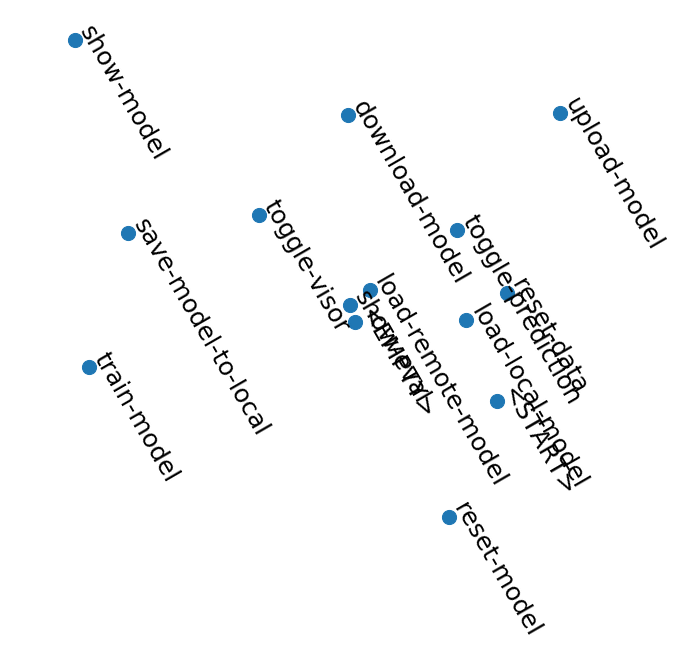

In [87]:
# for printing only
plt.figure(figsize=(10,10))
# plt.figure(dpi=600)
# plt.figure(dpi=300)

plt.axis('off')


plt.scatter(only_first[:, 0], only_first[:, 1], s=200)
for name, x_pos, y_pos in zip(encoder.classes_, only_first[:, 0], only_first[:, 1]):
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos),  rotation=-60, size=25)

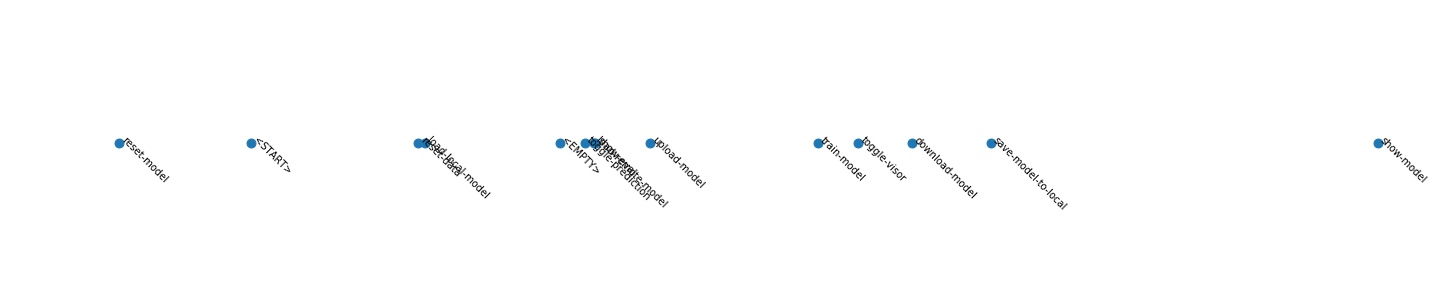

In [90]:
from sklearn.decomposition import PCA
import numpy as np

embeddings_1d = PCA(n_components=1).fit_transform(only_first)

# for printing only
plt.figure(figsize=(25,5))
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)), s=80)
for name, x_pos in zip(encoder.classes_, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=-45)

## Convert Model into tfjs format

In [0]:
model.save('ux.h5', save_format='h5')

In [0]:
!ls -l

total 88
drwxr-xr-x 1 root root  4096 Jun 18 16:14 sample_data
-rw-r--r-- 1 root root 83072 Jul  2 07:12 ux.h5


In [0]:
!pip install -q tensorflowjs

     |████████████████████████████████| 81kB 6.0MB/s 
ERROR: s3fs 0.2.1 has requirement six>=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.16 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
!tensorflowjs_converter --input_format keras ux.h5 tfjs

In [0]:
!ls -l tfjs

total 20
-rw-r--r-- 1 root root 14156 Jul  2 07:12 group1-shard1of1.bin
-rw-r--r-- 1 root root  3734 Jul  2 07:12 model.json


Download using _Files_ menu on the left